# Project - Fifth Requierement

### Import libraries and packages

In [65]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from itertools import product
from collections import deque
from scipy.optimize import linprog

## Environment

In [66]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

In [67]:
class PricingEnvironmentMultiProductPiecewiseMean:
    def __init__(self, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, total_rounds, num_of_intervals = 3):
        self.cost_vector = np.array(cost_vector)
        self.mean_valuations_list = [np.array(m) for m in mean_valuation_schedule]
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds
        self.current_round = 0
        self.interval_size = total_rounds // num_of_intervals # Compute the round thresholds

    def round(self, p_t_vector):
        # Set right interval
        if self.current_round < self.interval_size:
            mean_valuations = self.mean_valuations_list[0]
        elif self.current_round < 2 * self.interval_size:
            mean_valuations = self.mean_valuations_list[1]
        else:
            mean_valuations = self.mean_valuations_list[2]
        self.current_round += 1

        # Return reward
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
        reward = (np.array(p_t_vector) - self.cost_vector) * num_sales
        return num_sales, reward

### Global settings

In [68]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 3                # Independent trials

# --- Pricing Grid and Product Info ---

K = 4

costs = np.array([2.0, 2.5, 3.0])                                       # Costs per product

                                   #   P1    P2     P3
mean_valuation_schedule = np.array([[ 5.0, 10.0,  2.0],    # T1        # Mean valuations for each product at different time intervals
                                    [10.0,  5.0,  2.5],    # T2
                                    [ 3.0,  6.5, 12.0]])   # T3

std_valuations = np.array([1.0, 1.2, 0.8])                              # Std for each product

assert len(costs) == len(mean_valuation_schedule) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert all(costs[i] <= np.min(mean_valuation_schedule, axis=1)[i] for i in range(len(costs))), "Some costs exceed min mean valuation (likely leading to negative margin)"

price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = max(mean_valuation_schedule[:, i]) + 1.0
    price_grids.append(np.linspace(p_min, p_max, K))

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory
buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

w_size = int(np.round(np.sqrt(T)))                  # Sliding window size for UCB-SW
zoom_end_5 = 5000                                   # Start zooming 5k rounds
s = 30                                              # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

Let's visualize

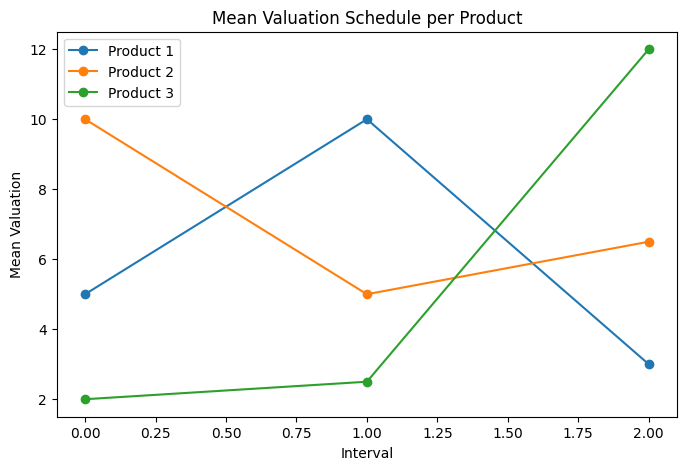

In [69]:
plt.figure(figsize=(8, 5))
for i in range(mean_valuation_schedule.shape[1]):
    plt.plot(range(mean_valuation_schedule.shape[0]), mean_valuation_schedule[:, i], marker='o', label=f'Product {i+1}')
plt.xlabel('Interval')
plt.ylabel('Mean Valuation')
plt.title('Mean Valuation Schedule per Product')
_ = plt.legend()

### Agents definition

Combinatorial

In [70]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.
R_ucb = np.array( [ buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N) ] ) / N 
C_lcb = np.array( [ buyers_per_round for _ in range(N) ] ) / N / w_size

class CombinatorialUCB_SW:
    def __init__(self, price_grids, R_ucb, C_lcb):
        # As before
        self.price_grids = price_grids
        self.R_ucb = R_ucb
        self.C_lcb = C_lcb
        self.rho = B / T if T > 0 else 1e-8
        self.t = 0
        self.inventory = B
        self.last_action_idx = None
        self.super_arms = list(product(range(K), repeat=N))
        self.A = len(self.super_arms)
        self.untried_superarms = set(self.super_arms)

        # Sliding window
        self.window_size = w_size
        self.reward_window = [deque(maxlen=self.window_size) for _ in range(self.A)]
        self.sales_window = [deque(maxlen=self.window_size) for _ in range(self.A)]

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        # Force exploration: pull each super-arm at least once
        if self.untried_superarms:
            a = self.untried_superarms.pop()
            self.last_action_idx = self.super_arms.index(a)
            return a

        # Compute UCB and LCB using sliding window stats
        ucb_rewards = np.zeros(self.A)
        lcb_sales = np.zeros(self.A)
        for a_idx, (rew_deque, sal_deque) in enumerate(zip(self.reward_window, self.sales_window)): 
            if len(rew_deque) == 0:
                ucb_rewards[a_idx] = float('inf')
                lcb_sales[a_idx] = 0
                continue
            ucb_rewards[a_idx] = np.mean(rew_deque) + sum(self.R_ucb[i] * np.sqrt(2 * np.log(T) / len(rew_deque)) for i in range(N))
            lcb_sales[a_idx] = max(0, np.mean(sal_deque) - sum(self.C_lcb[i] * np.sqrt(2 * np.log(T) / len(rew_deque)) for i in range(N)))

        # Solve LP
        action_idx = self.solve_lp(ucb_rewards, lcb_sales)
        self.last_action_idx = action_idx
        return self.super_arms[action_idx]

    # As before
    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            feasible = [i for i, c in enumerate(lcb_sales) if c <= self.rho]
            if feasible:
                return max(feasible, key=lambda i: ucb_rewards[i])
            else:
                return int(np.argmin(lcb_sales))

    # As before
    def update(self, sales, individual_rewards):
        if self.last_action_idx is None:
            return

        total_reward = np.sum(individual_rewards)
        total_sales = np.sum(sales)

        self.reward_window[self.last_action_idx].append(total_reward)
        self.sales_window[self.last_action_idx].append(total_sales)

        self.inventory -= total_sales
        self.t += 1
        self.rho = self.inventory / (T - self.t) if (T - self.t) > 0 else 0

Primal-Dual

In [71]:
# ------------ Primal ------------- #

class EXP3P:
    def __init__(self, K, gamma, eta, max_reward_scale):
        self.K = K
        self.gamma = gamma                          # Exploration rate (how much we don't trust our weights)
        self.eta = eta                              # Learning rate
        self.weights = np.ones(K)
        self.probabilities = np.zeros(K)
        self.max_reward_scale = max_reward_scale    # Safe upper bound on absolute reward

    def choose_action(self):
        # Compute distribution out of weights and choose 
        self.probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.K, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Compute loss with normalized reward in [0,1]  
        loss_t = (1 - observed_reward / self.max_reward_scale) / 2
        if self.probabilities[chosen_action_idx] != 0:
            estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        else:
            estimated_loss = loss_t
        # Update weights
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)
        # In case weights are getting too large or too small, re-normalize
        if np.sum(self.weights) < 1e-100 or np.sum(self.weights) > 1e100:
            self.weights /= np.max(self.weights)

# ------------- Primal-Dual ------------ #

class PrimalDualCombinatorialPricingAgent:
    def __init__(self, prices, costs, initial_lambda, learning_rate_lambda=0.01, exp3p_gamma=0.001):
        self.prices = prices  # This is now a list of N arrays: prices[i][k]
        self.costs = costs
        self.N = len(prices)
        self.K = len(prices[0])
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.superarms = list(product(range(self.K), repeat=self.N))
        self.remaining_budget = B
        self.current_round = 0
        self.max_reward_scale = np.sum([max(self.prices[i]) - self.costs[i] for i in range(self.N)]) * buyers_per_round
        self.history_lambda = [self.lambda_t]
        self.history_sales = []
        self.history_rho = [self.rho]

        self.primal_regret_minimizer = EXP3P(K=len(self.superarms), gamma=exp3p_gamma, eta=np.sqrt(np.log(len(self.superarms)) / (len(self.superarms) * T)), max_reward_scale=self.max_reward_scale)

        # Exploration queue
        self.explored = np.zeros((self.N, self.K), dtype=bool)
        self.exploration_queue = []
        for i in range(self.N):
            for k in range(self.K):
                arm = [np.random.choice(range(self.K)) for _ in range(self.N)]
                arm[i] = k
                self.exploration_queue.append(tuple(arm))
        self.exploration_queue = list(dict.fromkeys(self.exploration_queue))

    def pull_arm(self):
        # Initial exploration
        if not np.all(self.explored):
            superarm = self.exploration_queue.pop(0)
            prices = [self.prices[i][superarm[i]] for i in range(self.N)]
            for i in range(self.N):
                self.explored[i, superarm[i]] = True
            return prices, self.superarms.index(superarm)

        # Choose via EXP3P
        chosen_idx = self.primal_regret_minimizer.choose_action()
        chosen_superarm = self.superarms[chosen_idx]
        prices = [self.prices[i][chosen_superarm[i]] for i in range(self.N)]
        return prices, chosen_idx

    def update(self, chosen_idx, sales_vector):
        # Get the chosen superarm and compute the lagrangian reward
        chosen_superarm = self.superarms[chosen_idx]
        prices = [self.prices[i][chosen_superarm[i]] for i in range(self.N)]
        reward = np.sum([(prices[i] - self.costs[i]) * sales_vector[i] for i in range(self.N)])
        effective_reward = reward - self.lambda_t * (np.sum(sales_vector) - self.rho)

        # Update primal
        self.primal_regret_minimizer.update(chosen_idx, effective_reward)

        # New round
        self.remaining_budget -= np.sum(sales_vector)
        self.current_round += 1
        self.rho = self.remaining_budget / (T - self.current_round) if (T - self.current_round) > 0 else 1e-8
        self.history_rho.append(self.rho)

        # Logs
        self.history_sales.append(np.sum(sales_vector))
        if not hasattr(self, 'reward_per_superarm'):
            self.reward_per_superarm = {i: [] for i in range(len(self.superarms))}
        self.reward_per_superarm[chosen_idx].append(reward)

        # Update lambda
        self.lambda_t += self.eta_lambda * (np.sum(sales_vector) - self.rho)
        upper_bound_lambda = self.max_reward_scale
        self.lambda_t = np.clip(self.lambda_t, 0, upper_bound_lambda)
        self.history_lambda.append(self.lambda_t)

### Run the experiment

Run simulation.

In [72]:
# --- Dual-agent Simulation ---
all_rewards_dual = {'primal_dual': [], 'ucb_sw': []}
all_sales_dual = {'primal_dual': [], 'ucb_sw': []}

# Run simulation
for seed in range(n_trials):
    np.random.seed(seed)

    # Initialize two environments (identical structure, independent randomness)
    env1 = PricingEnvironmentMultiProductPiecewiseMean(cost_vector=costs, mean_valuation_schedule=mean_valuation_schedule, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T)
    env2 = PricingEnvironmentMultiProductPiecewiseMean(cost_vector=costs, mean_valuation_schedule=mean_valuation_schedule, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T)

    # Agent 1: Primal-Dual
    agent1 = PrimalDualCombinatorialPricingAgent(prices=price_grids, costs=costs, initial_lambda=5*N)
    agent2 = CombinatorialUCB_SW(price_grids=price_grids, R_ucb=R_ucb, C_lcb=C_lcb)

    # For every round
    rewards_1 = []
    rewards_2 = []
    sales1 = []
    sales2 = []
    for t in range(T):

        # Agent 1
        if agent1.remaining_budget >= 1:
            prices1, idxs1 = agent1.pull_arm()
            sales1_vec, reward_vec1 = env1.round(prices1)
            agent1.update(idxs1, sales1_vec)
            rewards_1.append(np.sum(reward_vec1))
            sales1.append(np.sum(sales1_vec))   # <-- track total sales
        else:
            rewards_1.append(0)
            sales1.append(0)

        # Agent 2
        arm2 = agent2.pull_arm()
        if arm2 is not None:
            price_vec2 = [price_grids[i][arm2[i]] for i in range(N)]
            sales2_vec, reward_vec2 = env2.round(price_vec2)
            agent2.update(sales2_vec, reward_vec2)
            rewards_2.append(np.sum(reward_vec2))
            sales2.append(np.sum(sales2_vec))   # <-- track total sales
        else:
            rewards_2.append(0)
            sales2.append(0)

    # Store cumulative info for both
    all_rewards_dual['primal_dual'].append(np.cumsum(rewards_1))
    all_rewards_dual['ucb_sw'].append(np.cumsum(rewards_2))
    all_sales_dual['primal_dual'].append(np.cumsum(sales1))
    all_sales_dual['ucb_sw'].append(np.cumsum(sales2))


Plot comparison

[ Primal - Dual ] Final cumulative reward: 1912696.31
[    UCB - SW   ] Final cumulative reward: 2187002.69


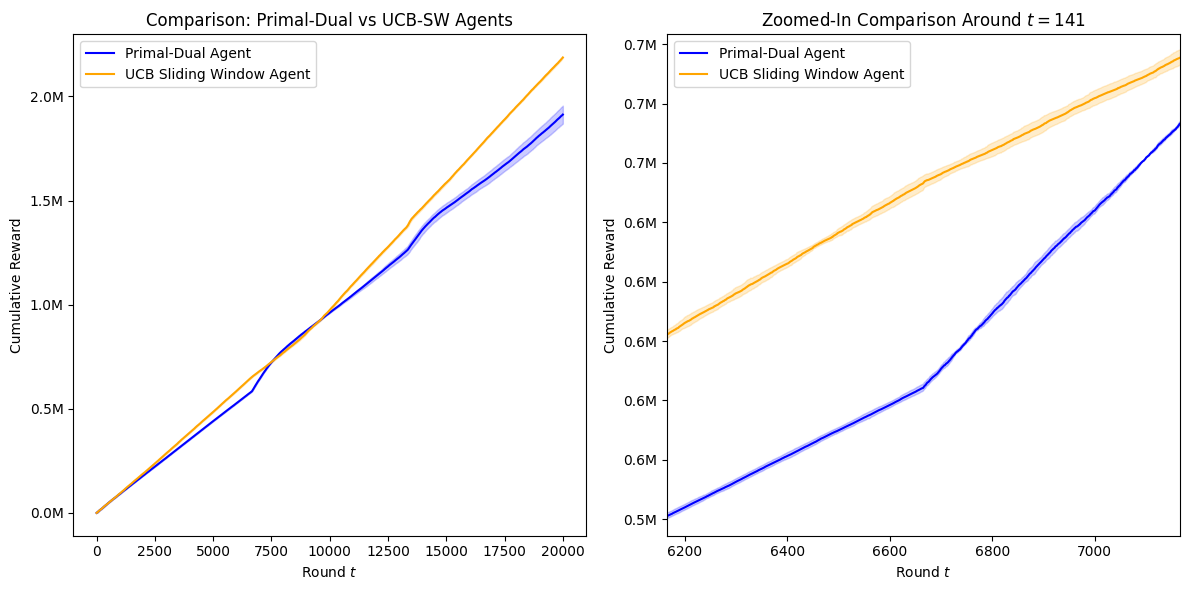

In [91]:
# Convert to numpy arrays
rewards_pd = np.array(all_rewards_dual['primal_dual'])   # shape (n_trials, T)
rewards_ucb = np.array(all_rewards_dual['ucb_sw'])

# Compute mean and std
mean_pd = np.mean(rewards_pd, axis=0)
std_pd = np.std(rewards_pd, axis=0)

mean_ucb = np.mean(rewards_ucb, axis=0)
std_ucb = np.std(rewards_ucb, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Top plot: full range
axs[0].plot(mean_pd, label='Primal-Dual Agent', color='blue')
axs[0].fill_between(np.arange(T), mean_pd - std_pd, mean_pd + std_pd, color='blue', alpha=0.2)
axs[0].plot(mean_ucb, label='UCB Sliding Window Agent', color='orange')
axs[0].fill_between(np.arange(T), mean_ucb - std_ucb, mean_ucb + std_ucb, color='orange', alpha=0.2)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Reward')
axs[0].set_title('Comparison: Primal-Dual vs UCB-SW Agents')
axs[0].legend()
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Bottom plot: zoom-in around t = w_size
axs[1].plot(mean_pd, label='Primal-Dual Agent', color='blue')
axs[1].fill_between(np.arange(T), mean_pd - std_pd, mean_pd + std_pd, color='blue', alpha=0.2)
axs[1].plot(mean_ucb, label='UCB Sliding Window Agent', color='orange')
axs[1].fill_between(np.arange(T), mean_ucb - std_ucb, mean_ucb + std_ucb, color='orange', alpha=0.2)
axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Reward')
axs[1].set_title(f'Zoomed-In Comparison Around $t = {w_size}$')
axs[1].legend()
axs[1].set_xlim(env1.interval_size - 500, env1.interval_size + 500)
axs[1].set_ylim(mean_pd[env1.interval_size] - 50000, mean_ucb[env1.interval_size] + 50000)
axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

plt.tight_layout()

# Print final utility
print(f"[ Primal - Dual ] Final cumulative reward: {mean_pd[-1]:.2f}")
print(f"[    UCB - SW   ] Final cumulative reward: {mean_ucb[-1]:.2f}")

Plot inventory consumption.

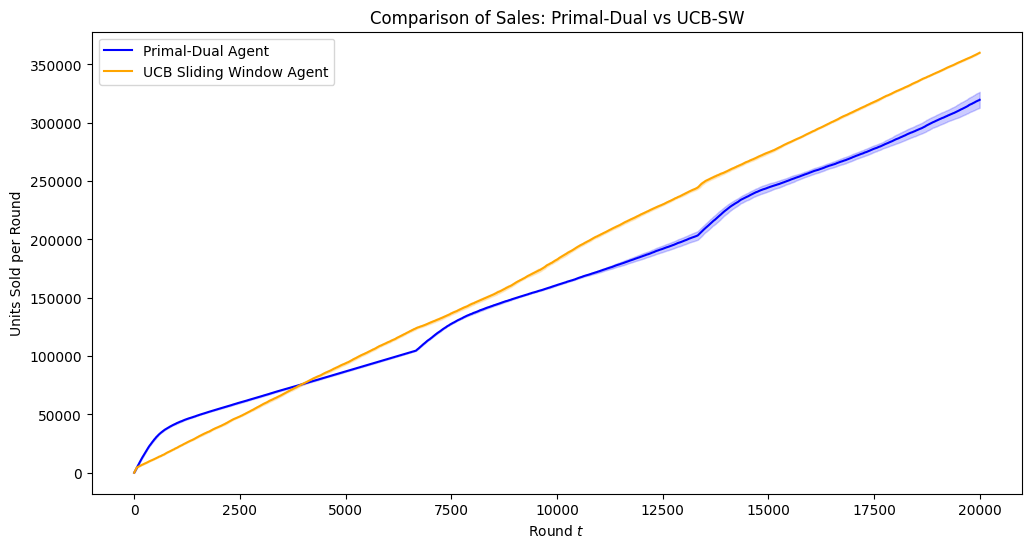

In [92]:
sales_pd = np.array(all_sales_dual['primal_dual'])   # shape (n_trials, T)
sales_ucb = np.array(all_sales_dual['ucb_sw'])

mean_sales_pd = np.mean(sales_pd, axis=0)
std_sales_pd = np.std(sales_pd, axis=0)

mean_sales_ucb = np.mean(sales_ucb, axis=0)
std_sales_ucb = np.std(sales_ucb, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_sales_pd, label='Primal-Dual Agent', color='blue')
plt.fill_between(np.arange(T), mean_sales_pd - std_sales_pd, mean_sales_pd + std_sales_pd, color='blue', alpha=0.2)

plt.plot(mean_sales_ucb, label='UCB Sliding Window Agent', color='orange')
plt.fill_between(np.arange(T), mean_sales_ucb - std_sales_ucb, mean_sales_ucb + std_sales_ucb, color='orange', alpha=0.2)

plt.xlabel('Round $t$')
plt.ylabel('Units Sold per Round')
plt.title('Comparison of Sales: Primal-Dual vs UCB-SW')
_ = plt.legend()